# Introduction to the Repsol Datathon Competition

Welcome to the Repsol Datathon Competition! This notebook contains the solutions to the challenge from the team Climate Coders! 🌎. With this we have developed an innovative solution to predict and optimize solar energy generation and consumption. We will be leveraging the different datasets provided by Repsol, machine learning and deep learning solutions to create models that can accurately forecast solar energy production and consumption patterns.


## Datasets

- `Energy Prediction.csv`: Contains timestamped data of the best LSTM model predictions for solar energy generation.
- `Generacion_fotovoltaica_imputed_mean.csv`: Contains imputed mean values for photovoltaic generation data.
- `ra_df.csv`: Contains detailed records of solar energy generated, consumed, and other related metrics.

## Objectives

The main objectives of the competition are:

1. **Predict Solar Energy Generation**: Develop models to accurately predict the amount of solar energy that will be generated at different times.
2. **Optimize Energy Consumption**: Create strategies to optimize the consumption of solar energy, minimizing waste and maximizing efficiency.
3. **Reduce Carbon Emissions**: Propose solutions that help reduce carbon emissions by optimizing the use of solar energy and integrating it with other energy sources.


In [14]:
#The first step will be to import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Exploratory Data Analysis

In [15]:
#Import relevant datasets

# Load solar generation data
solar_df = pd.read_csv("datasets/Generacion_fotovoltaica.csv")
# Load weather data
meteo = pd.read_csv("datasets/Meteorologia.csv")
consumption= pd.read_csv("datasets/Consumo_sept.csv")

In [16]:
# Check shape and preview
print(solar_df.shape)
print(solar_df.head())
print(solar_df.tail())

print(meteo.shape)
print(meteo.tail())

(9708, 2)
                 FECHA  TOTAL_KWH_ENERGIA
0  2023-07-24 11:00:00                NaN
1  2023-07-24 12:00:00             115.66
2  2023-07-24 13:00:00             129.98
3  2023-07-24 14:00:00             134.35
4  2023-07-24 15:00:00             133.90
                    FECHA  TOTAL_KWH_ENERGIA
9703  2024-08-31 19:00:00                NaN
9704  2024-08-31 20:00:00                NaN
9705  2024-08-31 21:00:00                NaN
9706  2024-08-31 22:00:00                NaN
9707  2024-08-31 23:00:00                NaN
(100557, 27)
               FORECAST_TIMESTAMP  LATITUDE  LONGITUDE  \
100552  2024-10-31 19:00:00+00:00      40.5       -3.5   
100553  2024-10-31 20:00:00+00:00      40.5       -3.5   
100554  2024-10-31 21:00:00+00:00      40.5       -3.5   
100555  2024-10-31 22:00:00+00:00      40.5       -3.5   
100556  2024-10-31 23:00:00+00:00      40.5       -3.5   

        10uheightAboveGround_10  10vheightAboveGround_10  \
100552                -1.515610               

In [17]:
solar_df.rename(columns={'FECHA': 'Datetime','TOTAL_KWH_ENERGIA': 'KWH_ENERGIA'}, inplace=True)

meteo.rename(columns={'FORECAST_TIMESTAMP': 'Datetime'}, inplace=True)

In [ ]:
# Convert solar datetime to timezone-aware if needed
solar_df['Datetime'] = pd.to_datetime(solar_df['Datetime'])

# Weather is in UTC → convert to Europe/Madrid
meteo['Datetime'] = pd.to_datetime(meteo['Datetime'])

In [21]:
#Create features extracted from the date:

solar_df['hour'] = solar_df['Datetime'].dt.hour
solar_df['day'] = solar_df['Datetime'].dt.day
solar_df['month'] = solar_df['Datetime'].dt.month
solar_df['year'] = solar_df['Datetime'].dt.year
solar_df['weekday'] = solar_df['Datetime'].dt.weekday  # Monday=0, Sunday=6

meteo['Datetime'].dt.tz is not None

True

In [22]:
#Check for missing values
print("Solar missing:\n", solar_df.isnull().sum())

Solar missing:
 Datetime          0
KWH_ENERGIA    1164
hour              0
day               0
month             0
year              0
weekday           0
dtype: int64


In [23]:
# Check for missing values
print("Solar missing:\n", solar_df.isnull().sum())
print("Weather missing:\n", meteo.isnull().sum())

#Check for 0 or negative solar generation
print(solar_df['KWH_ENERGIA'].describe())
print("Zero values:", (solar_df['KWH_ENERGIA'] == 0).sum())

Solar missing:
 Datetime          0
KWH_ENERGIA    1164
hour              0
day               0
month             0
year              0
weekday           0
dtype: int64
Weather missing:
 Datetime                        0
LATITUDE                        0
LONGITUDE                       0
10uheightAboveGround_10         0
10vheightAboveGround_10         0
2rheightAboveGround_2           0
2shheightAboveGround_2          0
2theightAboveGround_2           0
SUNSDsurface_0                  1
aptmpheightAboveGround_2        0
dlwrfsurface_0                  0
dswrfsurface_0                  0
gustsurface_0                   0
msletmeanSea_0                  0
presheightAboveGround_80        0
pwatatmosphereSingleLayer_0     0
qheightAboveGround_80           0
spsurface_0                     0
tccatmosphere_0                 0
theightAboveGround_80           0
tmaxheightAboveGround_2         0
tminheightAboveGround_2         0
tozneatmosphereSingleLayer_0    0
tpsurface_0                    

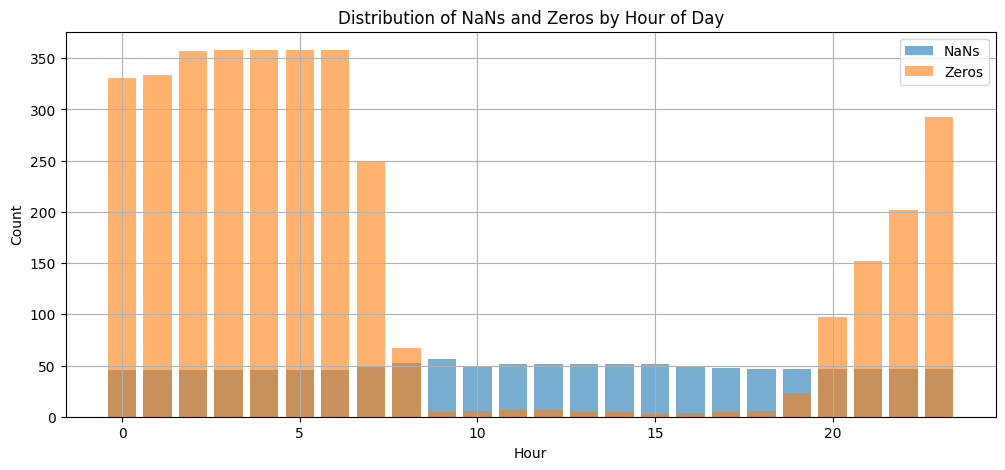

In [24]:
# Count NaNs by hour of the day
nan_by_hour = solar_df[solar_df['KWH_ENERGIA'].isna()]['hour'].value_counts().sort_index()
zero_by_hour = solar_df[solar_df['KWH_ENERGIA'] == 0]['hour'].value_counts().sort_index()

plt.figure(figsize=(12, 5))
plt.bar(nan_by_hour.index, nan_by_hour.values, alpha=0.6, label='NaNs')
plt.bar(zero_by_hour.index, zero_by_hour.values, alpha=0.6, label='Zeros')
plt.title("Distribution of NaNs and Zeros by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.legend()
plt.grid()
plt.show()

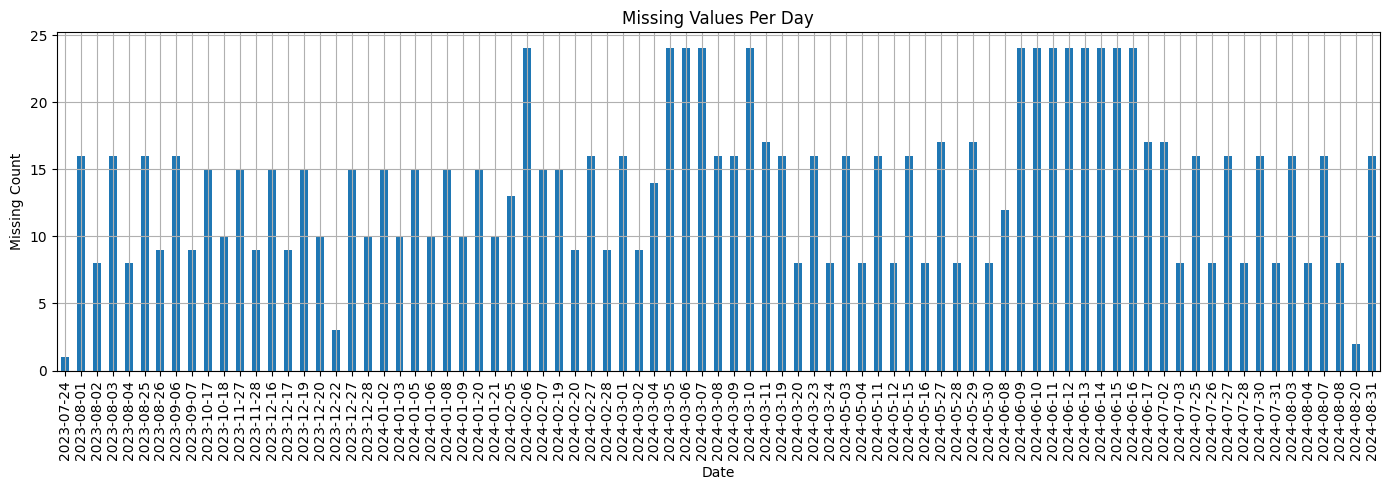

In [25]:
# Count missing values per day
solar_df['date'] = solar_df['Datetime'].dt.date
nan_per_day = solar_df[solar_df['KWH_ENERGIA'].isna()].groupby('date').size()

plt.figure(figsize=(14, 5))
nan_per_day.plot(kind='bar')
plt.title("Missing Values Per Day")
plt.xlabel("Date")
plt.ylabel("Missing Count")
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

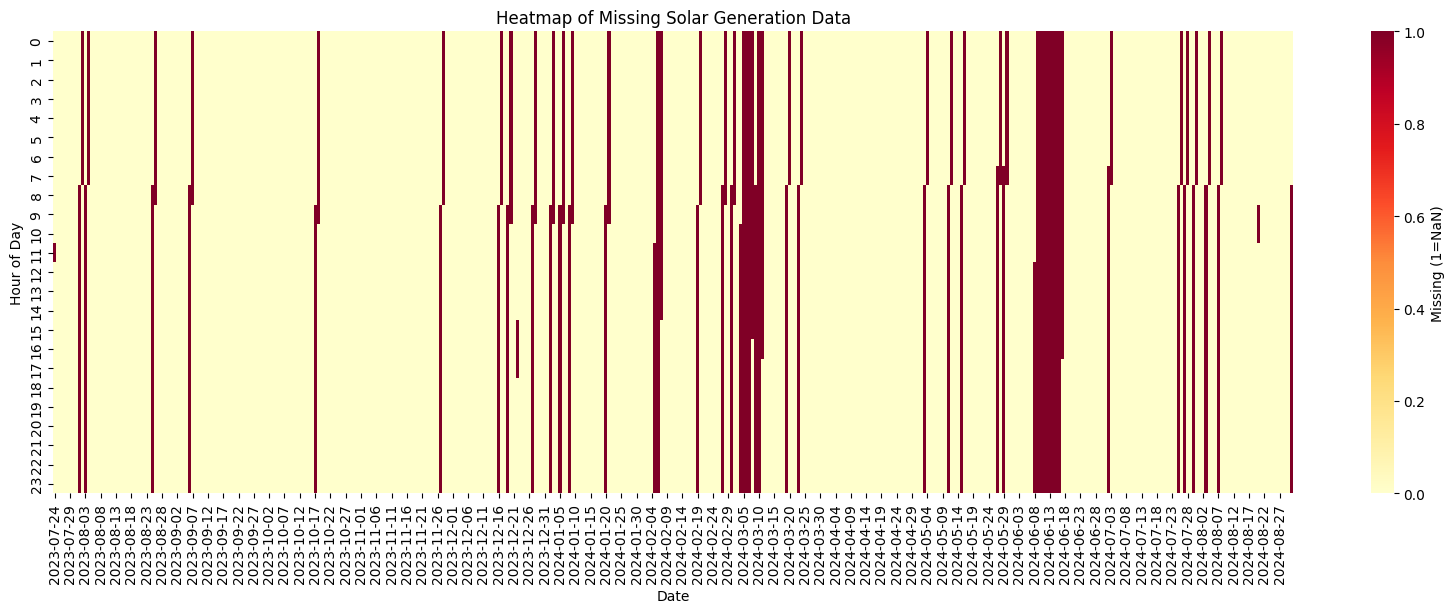

In [26]:
# Create a pivot table to see missing per hour per day
heat_df = solar_df.copy()
heat_df['hour'] = heat_df['Datetime'].dt.hour
heat_df['date'] = heat_df['Datetime'].dt.date
heat_df['missing'] = heat_df['KWH_ENERGIA'].isna().astype(int)

pivot = heat_df.pivot_table(index='hour', columns='date', values='missing', fill_value=0)

plt.figure(figsize=(20, 6))
sns.heatmap(pivot, cmap='YlOrRd', cbar_kws={'label': 'Missing (1=NaN)'})
plt.title("Heatmap of Missing Solar Generation Data")
plt.xlabel("Date")
plt.ylabel("Hour of Day")
plt.show()

In [27]:
#Clean the file to get rid of the missing values

# Rename columns to Prophet defaults
solar_df.rename(columns={'Datetime': 'ds', 'KWH_ENERGIA': 'y'}, inplace=True)

# Convert the 'ds' column to datetime
solar_df['ds'] = pd.to_datetime(solar_df['ds'])


solar_df['is_weekend'] = (solar_df['weekday'] >= 5).astype(int)  # 1 if Sat/Sun, else 0

#Augmented dataset
solar_df = solar_df[['ds', 'year', 'month', 'day', 'weekday', 'is_weekend', 'hour', 'y']]

# Clip negative values in 'y' to 0
solar_df['y'] = solar_df['y'].clip(lower=0)


solar_df

,ds,year,month,day,weekday,is_weekend,hour,y
0,2023-07-24 11:00:00,2023,7,24,0,0,11,NaN
1,2023-07-24 12:00:00,2023,7,24,0,0,12,115.66
2,2023-07-24 13:00:00,2023,7,24,0,0,13,129.98
3,2023-07-24 14:00:00,2023,7,24,0,0,14,134.35
4,2023-07-24 15:00:00,2023,7,24,0,0,15,133.90
...,...,...,...,...,...,...,...,...
9703,2024-08-31 19:00:00,2024,8,31,5,1,19,NaN
9704,2024-08-31 20:00:00,2024,8,31,5,1,20,NaN
9705,2024-08-31 21:00:00,2024,8,31,5,1,21,NaN
9706,2024-08-31 22:00:00,2024,8,31,5,1,22,NaN


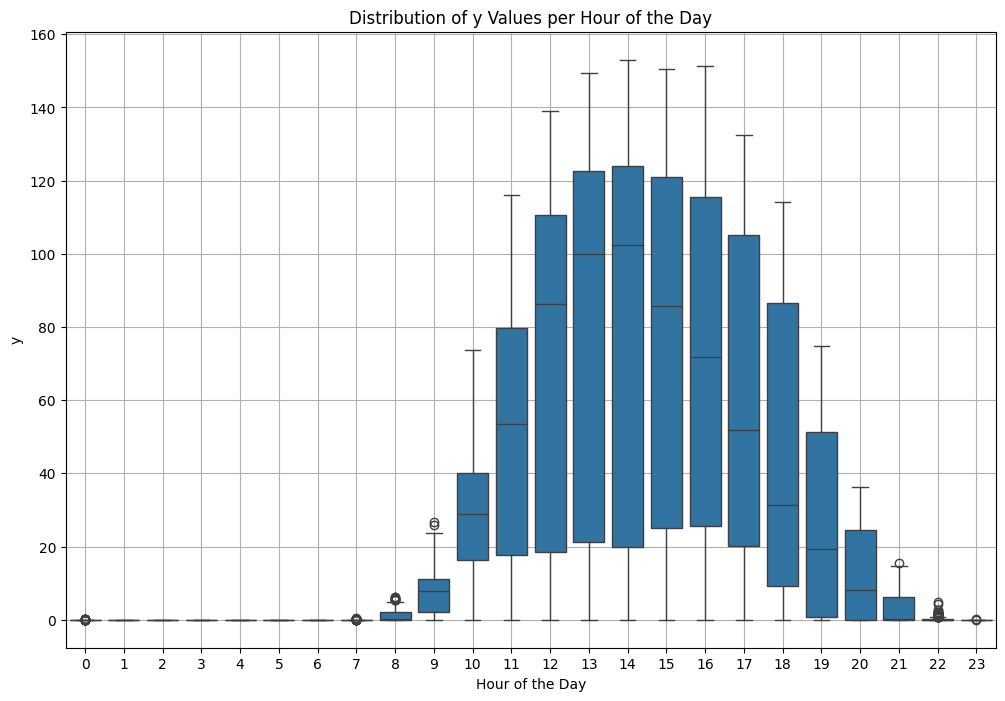

In [28]:
# Plot the distribution of 'y' values per hour
plt.figure(figsize=(12, 8))
sns.boxplot(x='hour', y='y', data=solar_df)
plt.xlabel('Hour of the Day')
plt.ylabel('y')
plt.title('Distribution of y Values per Hour of the Day')
plt.grid(True)
plt.show()

In [29]:
#From the previous graph we can see that the distribution per hour for the times when there is no sun is 0
#So we can safely assume that the missing values are 0 if they are in that time frame.

# Impute null values to 0 for the specified hours
solar_df.loc[solar_df['hour'].isin([22, 23, 0, 1, 2, 3, 4, 5, 6, 7]) & solar_df['y'].isnull(), 'y'] = 0

print(sum(solar_df['y'].isnull()))

699


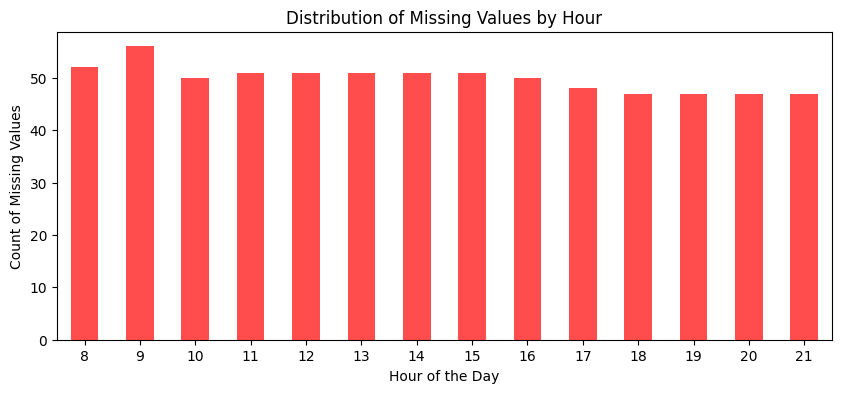

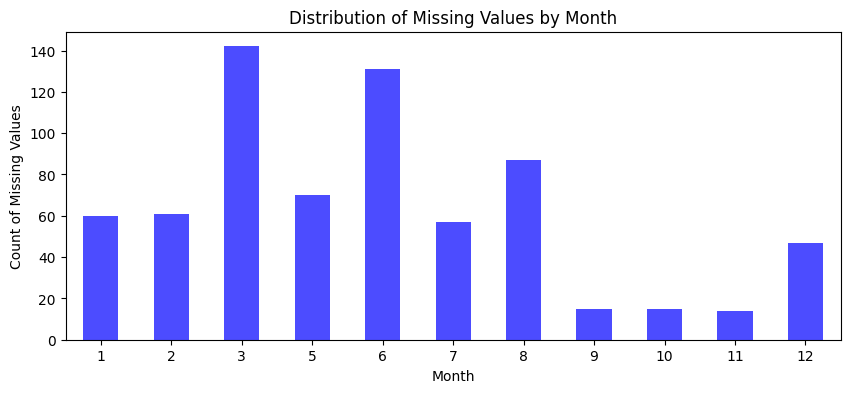

In [30]:

# Load the dataset (assuming it's already in memory)
solar_df_copy = solar_df.copy()

# Filter for remaining NaNs after zero imputation
df_missing = solar_df_copy[solar_df_copy['y'].isna()]

# Plot missing values by hour
plt.figure(figsize=(10, 4))
df_missing['hour'].value_counts().sort_index().plot(kind='bar', color='red', alpha=0.7)
plt.title('Distribution of Missing Values by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Count of Missing Values')
plt.xticks(rotation=0)
plt.show()

# Plot missing values by month
plt.figure(figsize=(10, 4))
df_missing['month'].value_counts().sort_index().plot(kind='bar', color='blue', alpha=0.7)
plt.title('Distribution of Missing Values by Month')
plt.xlabel('Month')
plt.ylabel('Count of Missing Values')
plt.xticks(rotation=0)
plt.show()


In [31]:
aux = solar_df.dropna()
hourly_mean = aux.groupby(aux['ds'].dt.hour)['y'].mean()
aux = pd.DataFrame(hourly_mean, columns=["y"])
aux

# Fill missing values with the hourly mean
solar_df['y'] = solar_df['y'].fillna(solar_df['hour'].map(hourly_mean))
solar_df.isnull().sum()

ds            0
year          0
month         0
day           0
weekday       0
is_weekend    0
hour          0
y             0
dtype: int64

### Now that we don't have missing values we can start working on the model

### Model 1: Prophet model to understand trends. 

We will not be using this model for the final predictions, however we decided to add it because we believe that it can give valuable insights for the business challenge as it is a model that is explainable.

In [ ]:
from prophet import Prophet

#We got the parameters from cross validation but for the sake of cleaning the code we are only putting the resulting model.
m = Prophet(
    changepoint_prior_scale=0.01,
    daily_seasonality=True,
    weekly_seasonality=Tprue
)

m.fit(solar_df)
future = m.make_future_dataframe(periods=720,freq='h')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ModuleNotFoundError: No module named 'prophet'

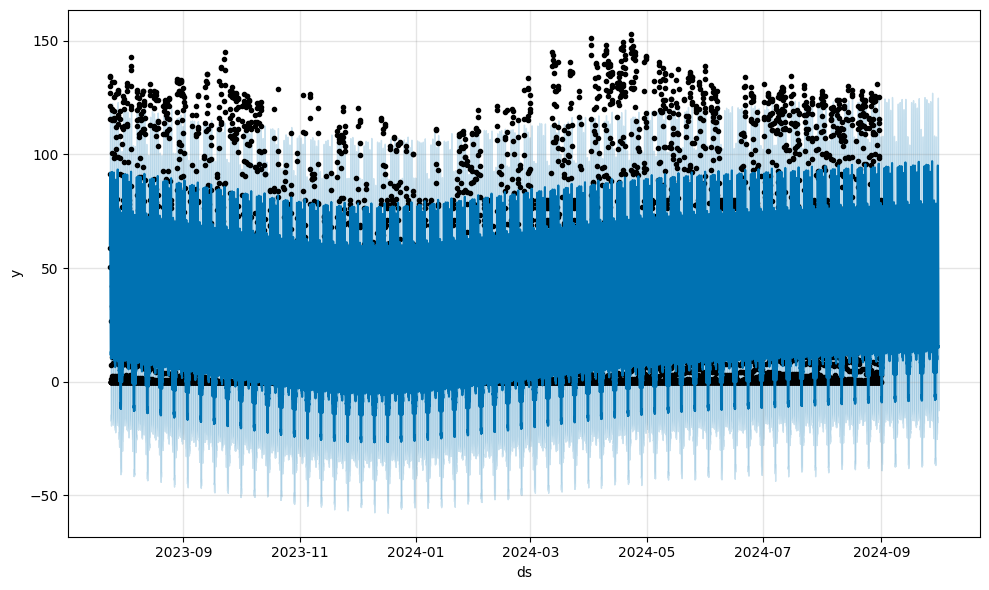

In [ ]:
fig1 = m.plot(forecast)

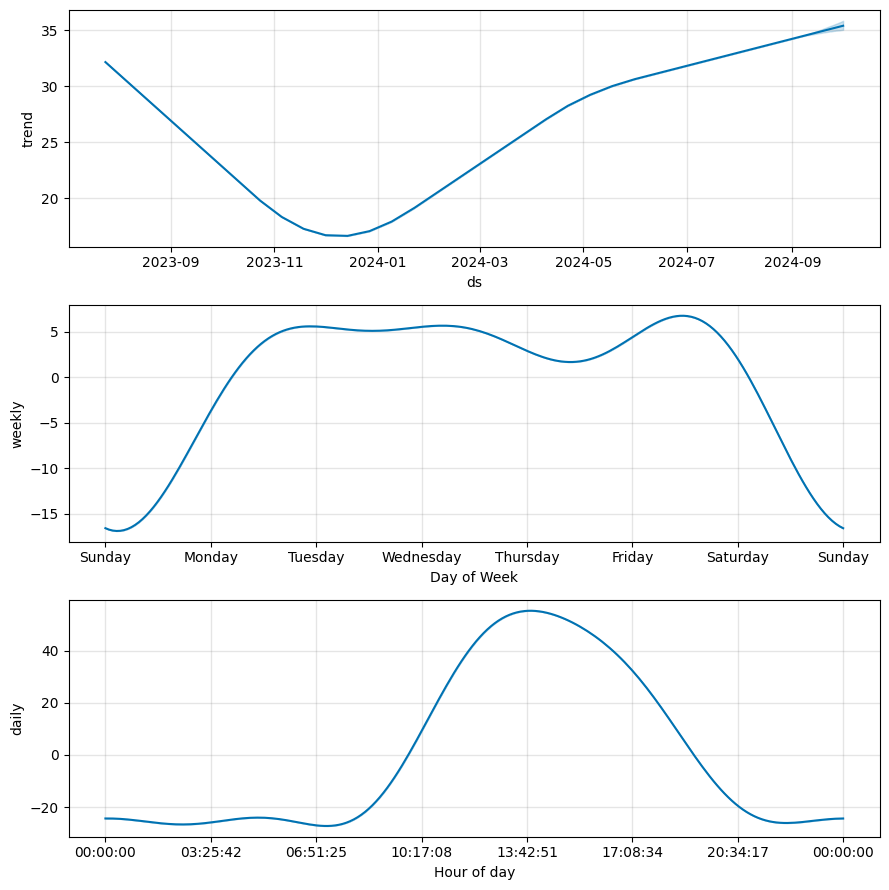

In [ ]:
fig2 = m.plot_components(forecast)

## Model #2: LSTM (Long Short Term Memory):

We are using this deep learning model to help us build the predictions.

In [32]:
#Augmented dataset
generation = solar_df[['ds', 'year', 'month', 'day', 'weekday', 'is_weekend', 'hour', 'y']]

# Clip negative values in 'y' to 0
generation['y'] = generation['y'].clip(lower=0)


generation

,ds,year,month,day,weekday,is_weekend,hour,y
0,2023-07-24 11:00:00,2023,7,24,0,0,11,50.621836
1,2023-07-24 12:00:00,2023,7,24,0,0,12,115.660000
2,2023-07-24 13:00:00,2023,7,24,0,0,13,129.980000
3,2023-07-24 14:00:00,2023,7,24,0,0,14,134.350000
4,2023-07-24 15:00:00,2023,7,24,0,0,15,133.900000
...,...,...,...,...,...,...,...,...
9703,2024-08-31 19:00:00,2024,8,31,5,1,19,26.665531
9704,2024-08-31 20:00:00,2024,8,31,5,1,20,12.582430
9705,2024-08-31 21:00:00,2024,8,31,5,1,21,2.981006
9706,2024-08-31 22:00:00,2024,8,31,5,1,22,0.000000


In [33]:
len(meteo["Datetime"].unique())

11173

In [34]:
meteo["avgtemp"] = (meteo["tmaxheightAboveGround_2"] + meteo["tmaxheightAboveGround_2"])/2

<Axes: >

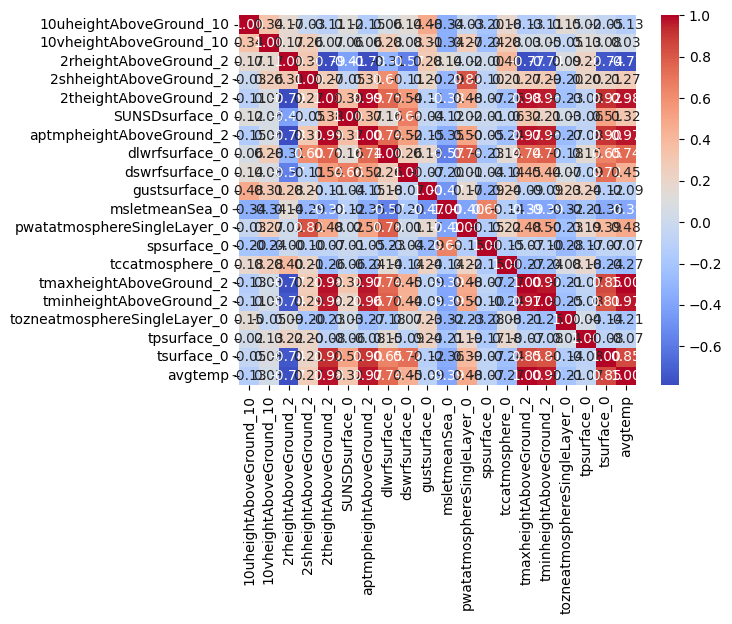

In [35]:
aux = meteo.drop(columns=['Datetime', 'LATITUDE', 'LONGITUDE'])
aux.drop(columns=["uheightAboveGround_80","vheightAboveGround_80","presheightAboveGround_80", "qheightAboveGround_80","theightAboveGround_80"], inplace=True)
sns.heatmap(aux.corr(), annot=True, cmap='coolwarm', fmt='.2f')

<Axes: >

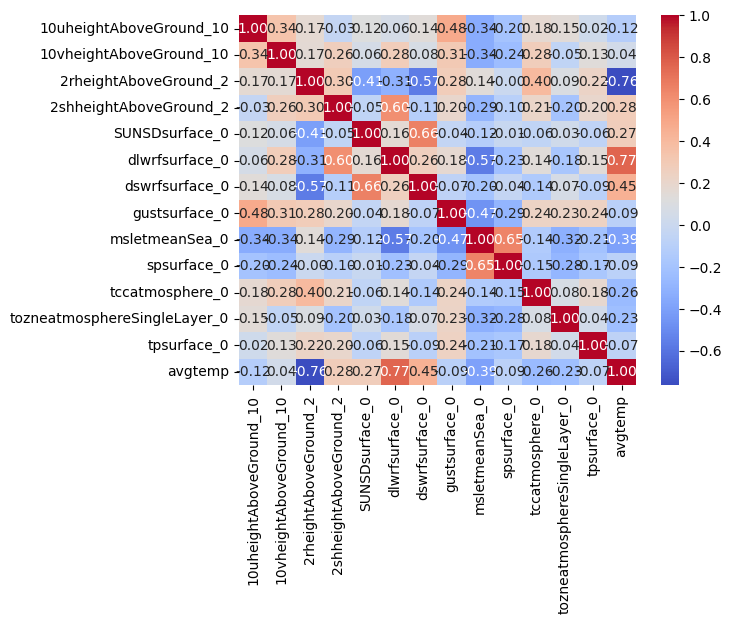

In [36]:
aux["avgtemp"] = (aux["tmaxheightAboveGround_2"] + aux["tminheightAboveGround_2"]) / 2
aux.drop(columns=["tsurface_0","pwatatmosphereSingleLayer_0", "2theightAboveGround_2","aptmpheightAboveGround_2", "tmaxheightAboveGround_2", "tminheightAboveGround_2"], inplace=True)
sns.heatmap(aux.corr(), annot=True, cmap='coolwarm', fmt='.2f')

In [37]:
#Drop high correlated columns
meteo.drop(columns=["uheightAboveGround_80","vheightAboveGround_80","presheightAboveGround_80", "qheightAboveGround_80","theightAboveGround_80", "tsurface_0","pwatatmosphereSingleLayer_0", "2theightAboveGround_2","aptmpheightAboveGround_2", "tmaxheightAboveGround_2", "tminheightAboveGround_2"], inplace=True)

In [38]:
# Group by FORECAST_TIMESTAMP and calculate the mean for all columns
meteo_averages = meteo.groupby('Datetime').mean()

# Display the resulting DataFrame
meteo_averages.head()

,LATITUDE,LONGITUDE,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,2shheightAboveGround_2,SUNSDsurface_0,dlwrfsurface_0,dswrfsurface_0,gustsurface_0,msletmeanSea_0,spsurface_0,tccatmosphere_0,tozneatmosphereSingleLayer_0,tpsurface_0,avgtemp
Datetime,,,,,,,,,,,,,,,,
2023-07-24 11:00:00+00:00,40.25,-3.75,5.176383,2.306685,17.577778,0.004644,18000.0,320.641024,568.753333,6.822393,100961.961111,94006.964236,2.700000,324.906396,0.0,301.843240
2023-07-24 12:00:00+00:00,40.25,-3.75,5.670802,2.579575,16.988889,0.004856,21600.0,324.429913,634.458667,7.719673,100871.676389,93949.704861,3.800000,325.770036,0.0,303.219008
2023-07-24 13:00:00+00:00,40.25,-3.75,6.260587,2.442148,17.077778,0.005225,3600.0,352.366667,979.857778,8.547689,100780.619444,93885.935417,38.833333,326.296606,0.0,304.326211
2023-07-24 14:00:00+00:00,40.25,-3.75,7.004427,2.025345,17.266667,0.005513,7200.0,356.926508,956.262222,9.332581,100706.934722,93829.203819,23.177778,327.157633,0.0,305.123018
2023-07-24 15:00:00+00:00,40.25,-3.75,7.471493,2.054768,17.411111,0.005703,10800.0,360.544444,914.748889,9.640562,100637.983333,93770.919444,58.177778,330.289266,0.0,305.617803


In [39]:
# Reset the index to bring FORECAST_TIMESTAMP back as a column
meteo_averages.reset_index(inplace=True)

# Convert FORECAST_TIMESTAMP to datetime if necessary
meteo_averages['Datetime'] = pd.to_datetime(meteo_averages['Datetime'])

In [40]:
meteo_averages.head()

,Datetime,LATITUDE,LONGITUDE,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,2shheightAboveGround_2,SUNSDsurface_0,dlwrfsurface_0,dswrfsurface_0,gustsurface_0,msletmeanSea_0,spsurface_0,tccatmosphere_0,tozneatmosphereSingleLayer_0,tpsurface_0,avgtemp
0,2023-07-24 11:00:00+00:00,40.25,-3.75,5.176383,2.306685,17.577778,0.004644,18000.0,320.641024,568.753333,6.822393,100961.961111,94006.964236,2.700000,324.906396,0.0,301.843240
1,2023-07-24 12:00:00+00:00,40.25,-3.75,5.670802,2.579575,16.988889,0.004856,21600.0,324.429913,634.458667,7.719673,100871.676389,93949.704861,3.800000,325.770036,0.0,303.219008
2,2023-07-24 13:00:00+00:00,40.25,-3.75,6.260587,2.442148,17.077778,0.005225,3600.0,352.366667,979.857778,8.547689,100780.619444,93885.935417,38.833333,326.296606,0.0,304.326211
3,2023-07-24 14:00:00+00:00,40.25,-3.75,7.004427,2.025345,17.266667,0.005513,7200.0,356.926508,956.262222,9.332581,100706.934722,93829.203819,23.177778,327.157633,0.0,305.123018
4,2023-07-24 15:00:00+00:00,40.25,-3.75,7.471493,2.054768,17.411111,0.005703,10800.0,360.544444,914.748889,9.640562,100637.983333,93770.919444,58.177778,330.289266,0.0,305.617803


In [41]:
meteo_filtered = meteo_averages.drop(columns=['LATITUDE', 'LONGITUDE'])
meteo_filtered['Datetime'] = meteo_filtered['Datetime'].dt.tz_localize(None)  # Remove timezone
generation['ds'] = generation['ds'].dt.tz_localize(None)  # Remove timezone from 'ds' if any

generation = generation.merge(meteo_filtered, left_on='ds', right_on='Datetime', how='left')

# Drop the 'Datetime' column after merging (if you don't need it)
generation.drop(columns=['Datetime'], inplace=True)

# Optionally, reorder the column 'y' back to its original position if needed
#aux = generation['y']
#generation = generation.drop(columns=['y'])
#generation['y'] = aux

# Display the first few rows of the result
generation.head()

,ds,year,month,day,weekday,is_weekend,hour,y,10uheightAboveGround_10,10vheightAboveGround_10,...,SUNSDsurface_0,dlwrfsurface_0,dswrfsurface_0,gustsurface_0,msletmeanSea_0,spsurface_0,tccatmosphere_0,tozneatmosphereSingleLayer_0,tpsurface_0,avgtemp
0,2023-07-24 11:00:00,2023,7,24,0,0,11,50.621836,5.176383,2.306685,...,18000.0,320.641024,568.753333,6.822393,100961.961111,94006.964236,2.700000,324.906396,0.0,301.843240
1,2023-07-24 12:00:00,2023,7,24,0,0,12,115.660000,5.670802,2.579575,...,21600.0,324.429913,634.458667,7.719673,100871.676389,93949.704861,3.800000,325.770036,0.0,303.219008
2,2023-07-24 13:00:00,2023,7,24,0,0,13,129.980000,6.260587,2.442148,...,3600.0,352.366667,979.857778,8.547689,100780.619444,93885.935417,38.833333,326.296606,0.0,304.326211
3,2023-07-24 14:00:00,2023,7,24,0,0,14,134.350000,7.004427,2.025345,...,7200.0,356.926508,956.262222,9.332581,100706.934722,93829.203819,23.177778,327.157633,0.0,305.123018
4,2023-07-24 15:00:00,2023,7,24,0,0,15,133.900000,7.471493,2.054768,...,10800.0,360.544444,914.748889,9.640562,100637.983333,93770.919444,58.177778,330.289266,0.0,305.617803


In [27]:
from sklearn.preprocessing import MinMaxScaler

generation["hour_sin"] = np.sin(2 * np.pi * generation["hour"] / 24)
generation["hour_cos"] = np.cos(2 * np.pi * generation["hour"] / 24)
generation.drop(["hour"], axis=1, inplace=True)

In [28]:
scalers = {}
for col in generation.columns:
    if col not in ["ds"]:  # Exclude timestamp
        scalers[col] = MinMaxScaler()
        generation[col] = scalers[col].fit_transform(generation[[col]])

In [30]:
generation.head()

,ds,year,month,day,weekday,is_weekend,y,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,...,dswrfsurface_0,gustsurface_0,msletmeanSea_0,spsurface_0,tccatmosphere_0,tozneatmosphereSingleLayer_0,tpsurface_0,avgtemp,hour_sin,hour_cos
0,2023-07-24 11:00:00,0.0,0.545455,0.766667,0.0,0.0,0.330754,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.629410,0.017037
1,2023-07-24 12:00:00,0.0,0.545455,0.766667,0.0,0.0,0.755701,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.000000
2,2023-07-24 13:00:00,0.0,0.545455,0.766667,0.0,0.0,0.849265,0.590779,0.527927,0.116773,...,0.563247,0.248037,0.427777,0.503320,0.027000,0.307271,0.0,0.695570,0.370590,0.017037
3,2023-07-24 14:00:00,0.0,0.545455,0.766667,0.0,0.0,0.877818,0.609859,0.539032,0.110265,...,0.628317,0.282421,0.410131,0.491380,0.038000,0.310399,0.0,0.729378,0.250000,0.066987
4,2023-07-24 15:00:00,0.0,0.545455,0.766667,0.0,0.0,0.874877,0.632620,0.533440,0.111248,...,0.970372,0.314150,0.392334,0.478083,0.388333,0.312307,0.0,0.756586,0.146447,0.146447


In [85]:
#missing_columns = generation.columns[generation.isnull().any()]
#print("Columns with missing values:", missing_columns)
#generation = generation.drop(columns=(missing_columns))

In [86]:
# Define the cutoff date for the train-test split
cutoff_date = '2024-07-31'
# Training data is strictly before the test period and avoids Data Leakage.
# No shuffling is done, preserving the Chronological Order.


# Split into train (before May 1st) and test (from May 1st onwards until June 1st)
train_df = generation[generation['ds'] <= cutoff_date]
test_df = generation[generation['ds'] > cutoff_date]

In [87]:
generation

,ds,year,month,day,weekday,is_weekend,y,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,...,dswrfsurface_0,gustsurface_0,msletmeanSea_0,spsurface_0,tccatmosphere_0,tozneatmosphereSingleLayer_0,tpsurface_0,avgtemp,hour_sin,hour_cos
0,2023-07-24 11:00:00,0.0,0.545455,0.766667,0.000000,0.0,0.330754,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.629410,0.017037
1,2023-07-24 12:00:00,0.0,0.545455,0.766667,0.000000,0.0,0.755701,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.000000
2,2023-07-24 13:00:00,0.0,0.545455,0.766667,0.000000,0.0,0.849265,0.590779,0.527927,0.116773,...,0.563247,0.248037,0.427777,0.503320,0.027000,0.307271,0.000000,0.695570,0.370590,0.017037
3,2023-07-24 14:00:00,0.0,0.545455,0.766667,0.000000,0.0,0.877818,0.609859,0.539032,0.110265,...,0.628317,0.282421,0.410131,0.491380,0.038000,0.310399,0.000000,0.729378,0.250000,0.066987
4,2023-07-24 15:00:00,0.0,0.545455,0.766667,0.000000,0.0,0.874877,0.632620,0.533440,0.111248,...,0.970372,0.314150,0.392334,0.478083,0.388333,0.312307,0.000000,0.756586,0.146447,0.146447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9703,2024-08-31 19:00:00,1.0,0.636364,1.000000,0.833333,1.0,0.174228,0.484434,0.509092,0.377333,...,0.365113,0.182763,0.432617,0.509428,0.985111,0.226869,0.007447,0.713636,0.017037,0.629410
9704,2024-08-31 20:00:00,1.0,0.636364,1.000000,0.833333,1.0,0.082211,0.458040,0.505530,0.411346,...,0.318120,0.146261,0.430231,0.504727,0.359333,0.225322,0.011022,0.713636,0.066987,0.750000
9705,2024-08-31 21:00:00,1.0,0.636364,1.000000,0.833333,1.0,0.019477,0.442784,0.470447,0.472741,...,0.022339,0.096622,0.441298,0.510163,0.152333,0.229205,0.001192,0.677347,0.146447,0.853553
9706,2024-08-31 22:00:00,1.0,0.636364,1.000000,0.833333,1.0,0.000000,0.407644,0.463103,0.496071,...,0.011173,0.066118,0.449921,0.514652,0.957000,0.232174,0.002085,0.677338,0.250000,0.933013


Now lets train the model

In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [89]:
class EnergyDataset(Dataset):
    def __init__(self, data, target_col="y", seq_length=6):
        self.data = data
        self.target_col = target_col
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        X = self.data.iloc[index:index + self.seq_length].drop(["ds", self.target_col], axis=1).values
        y = self.data.iloc[index + self.seq_length][self.target_col]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [90]:
seq_length = 6  # Use past 6 hours to predict the next value
train_dataset = EnergyDataset(train_df, seq_length=seq_length)
test_dataset = EnergyDataset(test_df, seq_length=seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  # No shuffling for time series
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [91]:
train_df.shape

(8941, 23)

In [92]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)  # Predicts one value per sequence

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Take the last time step output


# Initialize model
input_size = generation.shape[1] - 2  # Exclude "ds" and "y"
model = LSTMModel(input_size)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop
epochs = 20 #Change this value to train for more or less epochs. For the actual model we ran 20 epochs
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.5f}")

Epoch 1/20, Loss: nan
Epoch 2/20, Loss: nan
Epoch 3/20, Loss: nan
Epoch 4/20, Loss: nan


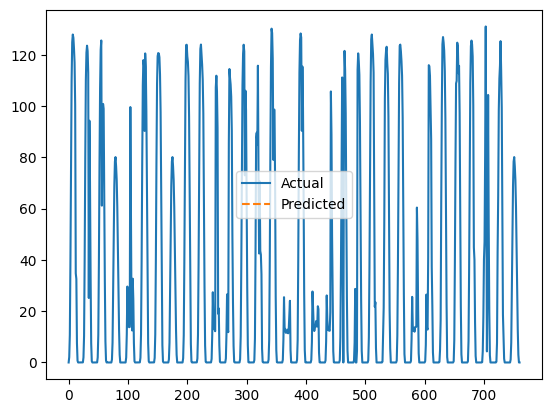

In [ ]:
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch).squeeze()
        predictions.extend(y_pred.tolist())
        actuals.extend(y_batch.tolist())

# Convert back from normalized scale
actuals = scalers["y"].inverse_transform(np.array(actuals).reshape(-1, 1))
predictions = scalers["y"].inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot results
import matplotlib.pyplot as plt

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted", linestyle="dashed")
plt.legend()
plt.show()

In [42]:
aux = generation.iloc[-24:].drop(["ds", "y"], axis=1).values
last_seq = torch.tensor(aux, dtype=torch.float32).unsqueeze(0)
len(last_seq)

1

In [43]:
def forecast_next_month(model, df, seq_length, steps=24*30):
    model.eval()
    df = df.drop(["ds"], axis=1)
    last_seq = df.iloc[-seq_length:].values
    last_seq = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0)

    future_preds = []
    for _ in range(steps):
        with torch.no_grad():
            pred = model(last_seq).item()
            future_preds.append(pred)

        # Update sequence for next prediction
        new_row = last_seq[:, 1:, :].clone()  # Shift left
        new_features = torch.tensor(df.iloc[-1].values, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        last_seq = torch.cat((new_row, new_features), dim=1)

    # Convert back from normalized scale
    future_preds = scalers["y"].inverse_transform(np.array(predictions).reshape(-1, 1))

    return future_preds

## From here under it's for generating the predicitons.

In [44]:
cutoff_date = '2024-09-01'
cutoff_date1 = '2024-10-01'
aux = meteo[meteo['Datetime'] > cutoff_date]
aux = aux[aux['Datetime'] < cutoff_date1]

In [ ]:
testdf = aux.groupby('Datetime').mean()

testdf.head()

,LATITUDE,LONGITUDE,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,2shheightAboveGround_2,SUNSDsurface_0,dlwrfsurface_0,dswrfsurface_0,gustsurface_0,msletmeanSea_0,spsurface_0,tccatmosphere_0,tozneatmosphereSingleLayer_0,tpsurface_0,avgtemp
Datetime,,,,,,,,,,,,,,,,
2024-09-01 01:00:00,40.25,-3.75,-2.270003,2.096686,57.344444,0.011643,2591.666667,384.860438,4.510222,5.211245,101164.470139,94108.255208,98.544444,302.061331,0.513889,301.100624
2024-09-01 02:00:00,40.25,-3.75,-2.767146,1.861814,61.322222,0.011785,2591.666667,384.755627,3.756444,5.842635,101199.586111,94125.605903,100.000000,300.937572,1.076389,301.101297
2024-09-01 03:00:00,40.25,-3.75,-2.001893,-0.224205,71.866667,0.012492,0.000000,370.518934,0.000000,3.640011,101224.335417,94125.645139,100.000000,301.242459,0.430556,295.659939
2024-09-01 04:00:00,40.25,-3.75,-2.005005,0.027773,74.811111,0.012621,0.000000,368.318983,0.000000,3.588243,101226.439583,94119.572222,99.477778,299.637897,1.006944,295.669406
2024-09-01 05:00:00,40.25,-3.75,-2.177849,-0.483426,75.255556,0.012733,0.000000,366.544444,0.000000,3.486075,101184.654167,94076.511806,85.600000,298.935765,1.215278,295.729473


In [46]:
testdf.reset_index(inplace=True)

# Convert FORECAST_TIMESTAMP to datetime if necessary
testdf['Datetime'] = pd.to_datetime(testdf['Datetime'])
testdf.drop(columns=['LATITUDE', 'LONGITUDE'], inplace=True)

In [47]:
future_dates = pd.date_range(start='2024-09-01 00:00:00', end='2024-09-30 23:00:00', freq='h')

# Create an empty DataFrame for predictions
future_df = pd.DataFrame({'ds': future_dates})

# Convert Timestamp Features
future_df['hour'] = future_df['ds'].dt.hour
future_df['year'] = future_df['ds'].dt.year
future_df['month'] = future_df['ds'].dt.month
future_df['day'] = future_df['ds'].dt.day
future_df['weekday'] = future_df['ds'].dt.weekday
future_df['is_weekend'] = (future_df['weekday'] >= 5).astype(int)

In [48]:
testdf['Datetime'] = testdf['Datetime'].dt.tz_localize(None)  # Remove timezone
future_df['ds'] = future_df['ds'].dt.tz_localize(None)  # Remove timezone from 'ds' if any

future_df = future_df.merge(testdf, left_on='ds', right_on='Datetime', how='left')
future_df.drop(columns=['Datetime'], inplace=True)

In [49]:
# Apply Cyclical Encoding
future_df['hour_sin'] = np.sin(2 * np.pi * future_df['hour'] / 24)
future_df['hour_cos'] = np.cos(2 * np.pi * future_df['hour'] / 24)
future_df.drop(["hour"], axis=1, inplace=True)

In [50]:
scalers1 = {}
for col in future_df.columns:
    if col not in ["ds"]:  # Exclude timestamp
        scalers[col] = MinMaxScaler()
        future_df[col] = scalers[col].fit_transform(future_df[[col]])

In [51]:
future_df

,ds,year,month,day,weekday,is_weekend,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,2shheightAboveGround_2,...,dswrfsurface_0,gustsurface_0,msletmeanSea_0,spsurface_0,tccatmosphere_0,tozneatmosphereSingleLayer_0,tpsurface_0,avgtemp,hour_sin,hour_cos
0,2024-09-01 00:00:00,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,1.000000
1,2024-09-01 01:00:00,0.0,0.0,0.0,1.0,1.0,0.228535,0.704658,0.629144,0.893547,...,0.005245,0.293181,0.421385,0.474275,0.985444,0.242099,0.086651,0.827539,0.629410,0.982963
2,2024-09-01 02:00:00,0.0,0.0,0.0,1.0,1.0,0.198802,0.688282,0.680744,0.907418,...,0.004368,0.333398,0.437201,0.483832,1.000000,0.220704,0.181499,0.827572,0.750000,0.933013
3,2024-09-01 03:00:00,0.0,0.0,0.0,1.0,1.0,0.244571,0.542835,0.817527,0.976431,...,0.000000,0.193098,0.448349,0.483854,1.000000,0.226509,0.072600,0.562492,0.853553,0.853553
4,2024-09-01 04:00:00,0.0,0.0,0.0,1.0,1.0,0.244385,0.560404,0.855722,0.989027,...,0.000000,0.189801,0.449296,0.480509,0.994778,0.195960,0.169789,0.562954,0.933013,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,2024-09-30 19:00:00,0.0,0.0,1.0,0.0,0.0,0.421826,0.648098,0.132747,0.175847,...,0.613254,0.085880,0.601681,0.713632,0.021556,0.096106,0.000000,0.757182,0.017037,0.629410
716,2024-09-30 20:00:00,0.0,0.0,1.0,0.0,0.0,0.405064,0.640401,0.179158,0.184041,...,0.519993,0.097904,0.622113,0.719667,0.058889,0.094352,0.000000,0.757182,0.066987,0.750000
717,2024-09-30 21:00:00,0.0,0.0,1.0,0.0,0.0,0.389984,0.620306,0.199193,0.187031,...,0.000000,0.070475,0.642620,0.730988,0.049778,0.093175,0.000000,0.616439,0.146447,0.853553
718,2024-09-30 22:00:00,0.0,0.0,1.0,0.0,0.0,0.383768,0.610923,0.214471,0.189216,...,0.000000,0.042504,0.650561,0.732218,0.047444,0.129316,0.000000,0.616439,0.250000,0.933013


In [52]:
def predict_future_values(model, future_df, seq_length):
    model.eval()
    future_df = future_df.drop(["ds"], axis=1)  # Drop the timestamp column
    last_seq = future_df.iloc[-seq_length:].values  # Get the last sequence
    last_seq = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0)  # Convert to tensor and add batch dimension

    predictions = []
    for _ in range(len(future_df)):
        with torch.no_grad():
            pred = model(last_seq).item()  # Predict the next value
            predictions.append(pred)

        # Update the sequence for the next prediction
        new_row = last_seq[:, 1:, :].clone()  # Shift left
        new_features = torch.tensor(future_df.iloc[_].values, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        last_seq = torch.cat((new_row, new_features), dim=1)

    # Convert predictions back from normalized scale
    predictions = np.array(predictions).reshape(-1, 1)

    predictions_original_scale = scalers["y"].inverse_transform(np.array(predictions).reshape(-1, 1))

    return predictions_original_scale

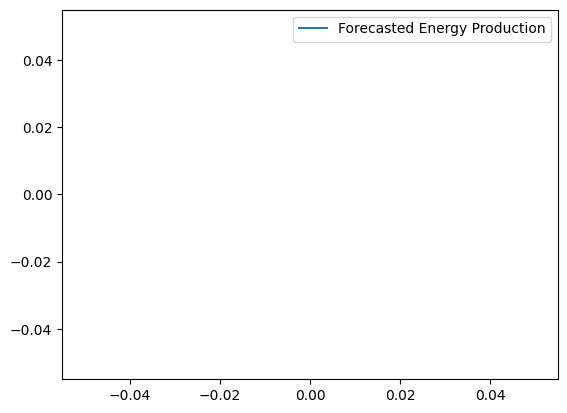

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
      

In [ ]:
future_predictions = predict_future_values(model, future_df, seq_length)

# Plot future predictions
plt.plot(future_predictions, label="Forecasted Energy Production")
plt.legend()
plt.show()
future_predictions

In [ ]:
submission_df = pd.DataFrame(columns=['ds', 'Energia'])
submission_df['ds'] = future_df["ds"]
submission_df['Energia'] = future_predictions
submission_df.head()

In [ ]:
submission_filename = 'EnergyPrediction.csv'  # Replace 'GroupX' with your team name if needed

#print(f"✅ Submission file saved as '{submission_filename}'")
pd.options.display.float_format = "{:.6f}".format


# Clip the values of 'Energia' column lower than 0.5 to 0
submission_df['Energia'] = submission_df['Energia'].apply(lambda x: 0 if x < 0.5 else x)
for i in submission_df.index:
    if submission_df.loc[i, 'ds'].hour in [22, 23, 0, 1, 2, 3, 4, 5, 6, 7]:
        submission_df.loc[i, 'Energia'] = 0
submission_df.to_csv(submission_filename, index=False, sep=";", decimal=",")
submission_df.head(20)